# Lab 7 - few-shot learning and hypernetworks

Plan for today:
* learn about the concept of few-shot learning
* familiarize ourselves with hypernetworks
* connect those two concepts by implementing a technique from [this paper](https://arxiv.org/pdf/1706.03466.pdf).

In [1]:
%pip install learn2learn

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metad

You should consider upgrading via the 'd:\Programy\DataSpell 2022.2.3\DataspellProjects\SimCLRPytorch-main\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [67]:
import torch
from torchvision.datasets import Omniglot, EMNIST
from torchvision import transforms as T
import learn2learn as l2l
import matplotlib.pyplot as plt
from learn2learn.data import MetaDataset, TaskDataset
from learn2learn.vision.models import OmniglotCNN
from torch import nn
from typing import Tuple
import matplotlib.pyplot as plt


## Few-shot learning

In general, neural networks require huge amounts of data to train well. Few-shot learning techniques aim to construct models, which are capable of quickly adapting to numerous **tasks** based on limited amounts of data.

One of the most popular usecases for FSL is image classification. We define $K$-shot, $N$-way classification as the task of classifying between $N$ classes based on $K$ examples for each of the classes, called the **support set**. The model is then tasked with classifying the **query set** of previously unseen images, which belong to the same set of $N$ classes.

During training, we construct **tasks** consisting of support and query examples from a set of training classes and taks the model with adapting to those tasks.

We evaluate the model on tasks sampled from a set of classes **separate from the training set** - after all, we want to measure how well the model adapts to previously unseen tasks!



One of the most popular datasets for FSL is Omniglot. 

### Task for you - import the omniglot dataset from the [learn2learn](http://learn2learn.net/) package and visualize an example task:
* sample a single task from the tasksets
* draw a grid with images and their classes

d:\Programy\DataSpell 2022.2.3\DataspellProjects\SimCLRPytorch-main\venv\lib\site-packages\torchvision\transforms\transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


Files already downloaded and verified


Files already downloaded and verified


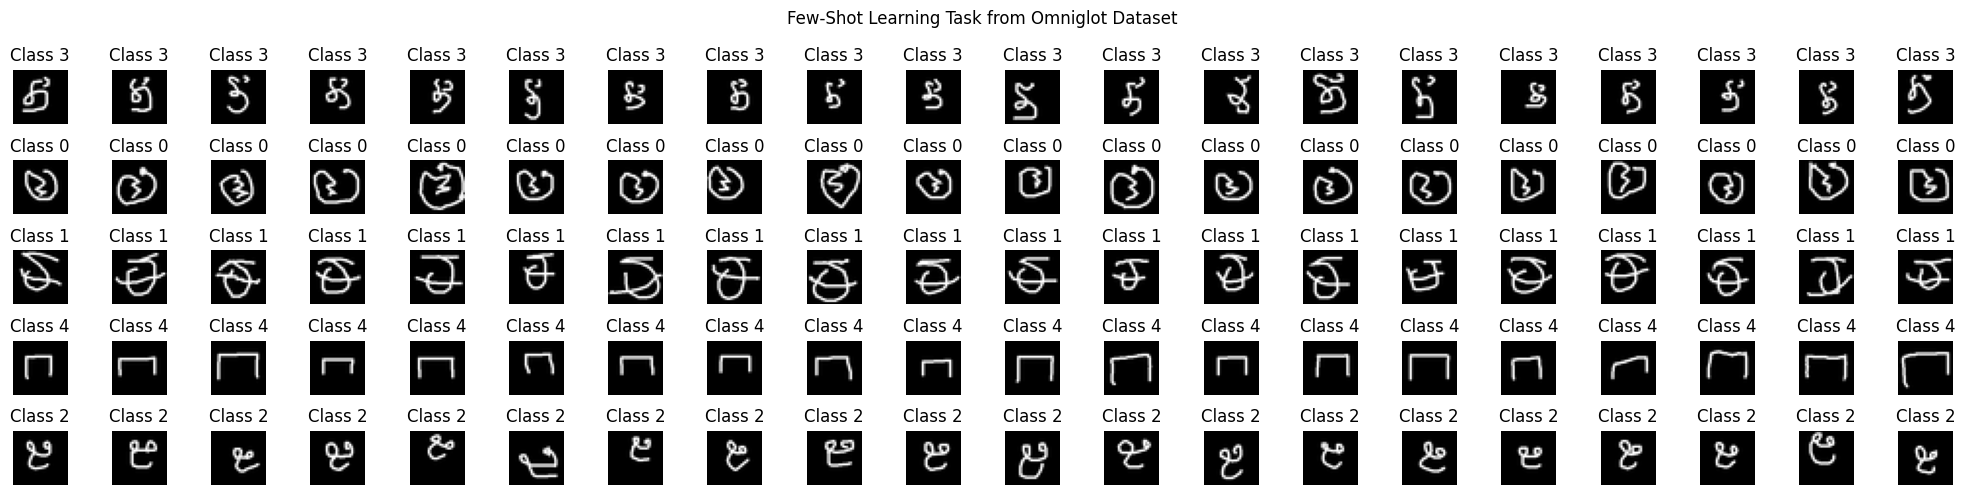

In [83]:
shots = 5
queries = 15
ways = 5


tasksets = l2l.vision.benchmarks.get_tasksets('omniglot',
                                                  train_ways=ways,
                                                  train_samples=shots + queries,
                                                  test_ways=ways,
                                                  test_samples=shots + queries,
                                                  num_tasks=20000,
                                                  root='~/data',
                                              
    )

for X, y in tasksets.train:
  break

# your code here - visualize the examples from X
# Convert the tensors to numpy arrays for visualization
Xnp = X.numpy()
ynp = y.numpy()

# Create a grid for visualization
fig, axes = plt.subplots(ways, shots + queries, figsize=(shots + queries, ways))
fig.suptitle('Few-Shot Learning Task from Omniglot Dataset')

# Plot each image and its corresponding label
for i in range(ways):
    for j in range(shots + queries):
        axes[i, j].imshow(Xnp[i * (shots + queries) + j].reshape(28, 28), cmap='gray')
        axes[i, j].axis('off')
        axes[i, j].set_title(f'Class {ynp[i * (shots + queries) + j]}')

plt.tight_layout()
plt.show()

In [63]:
X.shape

(100, 1, 28, 28)

## Hypernetworks

Hypernetworks are models which, based on some condition, predict weights of other neural networks, which perform the downstream tasks. The concept has been utilized in many fields, such as generative models, point clouds, condtional flows, as well as few-shot learning.


## Bringing it all together - Parameter Prediction from Activations

Today, we will utilize the hypernets in the task of FSL. We will base our solution on the [Few-Shot Image Recognition by Predicting Parameters from Activations](https://arxiv.org/pdf/1706.03466.pdf).

The PPA model consists of:
* a convolutional backbone
* a parameter prediction hypernet

First, we process the support and query samples through the backbone and obtain embeddings $E$ Next, we want to predict the weights of the classifier which will transform $E$ into classes $C$. The classifier is therefore a linear layer with dimentionality $(E, C)$.

We can predict the weights of the classifier in several ways:
* concatenate all of the support embeddings and predict all of the classifier parameters
* predict the *portion* of parameters of shape $(E, 1)$ dedicated to predicting class $C$ based only on the support embeddings from that class. Then, concatenate all portions into weights of shape $(E, C)$.



### Task for you - implement the few-shot hypernetwork
* implement two variants of classifier generation:
  * generating **all** weights based on **all** support class embeddings
  * generating **weight fragments** responsible for predicting class $C$ based solely on support embbedings of class $C$


In [91]:
class Hypernet(nn.Module):
  def __init__(self, n_shot: int, n_way: int, hidden_size: int = 64, weights_per_class: bool = True):
    super().__init__()
    self.cnn = OmniglotCNN(hidden_size=hidden_size).features 
    # a convolutional net which transforms an image of shape (1, 28, 28) to vectors of shape `hidden_size`

    ##self.weight_predictor = ... 
    # a neural network that tranforms vectors of shape [n_classes, n_shots, hidden_size] into the weights of a classifier

    self.hidden_size = hidden_size
    self.n_way = n_way
    self.n_shot = n_shot
    self.weights_per_class = weights_per_class
    
    if weights_per_class:
        # Predict weight fragments
        self.weight_predictor = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size)
        )
    else:
        # Predict all weights
        self.weight_predictor = nn.Sequential(
            nn.Linear(n_way * n_shot * hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_way * hidden_size)
        )

  def forward(
      self, 
      support_examples: torch.Tensor, 
      support_labels: torch.Tensor,
      query_examples: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    support_examples: [n_shot * n_way, 1, 28, 28]
    support_labels: [n_shot * n_way]
    query_samples: [n_query]

    Returns a tuple of logits:
      (y_pred_support, y_pred_query)
      of shapes:
      (
        [n_shot * n_way, n_way],
        [n_query, n_way]        
      ) 
    """

    # 1: process the supports and queries through the cnn
    # 2: generate the weights of the classifier based on the support embeddings
    # 3: classify the support and query embeddings with the generated weights

    print(support_examples.size())
    support_embeddings = self.cnn(support_examples)
    query_embeddings = self.cnn(query_examples)
    
    if self.weights_per_class:
        print("weight exists")
        # Generate weight fragments for each class
        classifier_weights = []
        for i in range(self.n_way):
            class_embeddings = support_embeddings[support_labels == i]
            class_weights = self.weight_predictor(class_embeddings.mean(dim=0))
            classifier_weights.append(class_weights)
        classifier_weights = torch.stack(classifier_weights)#.view(self.n_way,self.hidden_size)#, dim=1
    else:
        # Generate all weights based on all support embeddings
        print("else based on all support embeddings")
        support_embeddings = support_embeddings.view(1,-1)#(self.n_way, self.n_shots, self.hidden_size)
        classifier_weights = self.weight_predictor(support_embeddings).view(self.n_way,self.hidden_size)#lub na odwrot
    
    support_embeddings = support_embeddings.view(-1,self.hidden_size)
    support_logits = torch.matmul(support_embeddings, classifier_weights.T)
    query_logits = torch.matmul(query_embeddings, classifier_weights.T)
    
    return support_logits, query_logits




In [48]:
shots = 5
queries = 15
ways = 5


tasksets = l2l.vision.benchmarks.get_tasksets('omniglot',
                                                  train_ways=ways,
                                                  train_samples=shots + queries,
                                                  test_ways=ways,
                                                  test_samples=shots + queries,
                                                  num_tasks=20000,
                                                  root='~/data',
                                              
    )

d:\Programy\DataSpell 2022.2.3\DataspellProjects\SimCLRPytorch-main\venv\lib\site-packages\torchvision\transforms\transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified


### Task for you - finish implementing the training loop:
* add the necessary training loss and optimizer parts
* track the meta-training and meta-validation losses and accuracies throughout the training epochs and plot them after the training
* train the two variants of hypernetwork on Omniglot 
* train the hypernets in two settings:
  * 1-shot, 5-way
  * 5-shot, 5-way

In [88]:
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
def train_hypernet(
    hypernet: Hypernet,
    tasksets,
    optimizer,
    num_epochs: int = 20,
    n_shot: int = shots,
    n_query: int = queries,
    n_ways: int = ways,
    img_shape = (1, 28, 28)
):

  for e in range(num_epochs):
    # meta-training:

    for X, y in tasksets.train:
      # reshape X and y to have each class in a separate row
      X = X.reshape(n_ways, n_shot+n_query, *img_shape)
      y = y.reshape(n_ways, n_shot+n_query,)

      # separate support from query
      X_support, X_query = X[:, :n_shot], X[:, n_shot:]
      y_support, y_query = y[:, :n_shot], y[: ,n_shot:]

      # re-flatten the tensors
      X_support = X_support.reshape(n_ways * n_shot, *img_shape)
      X_query = X_query.reshape(n_ways * n_query, *img_shape)
      y_support = y_support.reshape(n_ways * n_shot)
      y_query = y_query.reshape(n_ways * n_query)


      # predictions
      y_support_pred, y_query_pred = hypernet(X_support.to(device), y_support.to(device), X_query.to(device))

      # YOUR CODE HERE
      # 
      #####
      optimizer.zero_grad()
      support_loss = criterion(y_support_pred, y_support)
      query_loss = criterion(y_query_pred, y_query)
      loss = support_loss + query_loss
      loss.backward()
      optimizer.step()

      train_loss += loss.item()
      _, predicted = torch.max(y_query_pred, 1)
      train_correct += (predicted == y_query).sum().item()
      train_total += y_query.size(0)
    avg_train_loss = train_loss / len(tasksets.train)
    train_accuracy = train_correct / train_total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

      


    # meta-validation
    for X, y in tasksets.train:
      # reshape X and y to have each class in a separate row
      X = X.reshape(n_ways, n_shot+n_query, *img_shape)
      y = y.reshape(n_ways, n_shot+n_query,)

      # separate support from query
      X_support, X_query = X[:, :n_shot], X[:, n_shot:]
      y_support, y_query = y[:, :n_shot], y[: ,n_shot:]

      # re-flatten the tensors
      X_support = X_support.reshape(n_ways * n_shot, *img_shape)
      X_query = X_query.reshape(n_ways * n_query, *img_shape)
      y_support = y_support.reshape(n_ways * n_shot)
      y_query = y_query.reshape(n_ways * n_query)

      # YOUR CODE HERE
      # 
      ####
      y_support_pred, y_query_pred = hypernet(X_support.to(device), y_support.to(device), X_query.to(device))
      support_loss = criterion(y_support_pred, y_support)
      query_loss = criterion(y_query_pred, y_query)
      loss = support_loss + query_loss

      val_loss += loss.item()
      _, predicted = torch.max(y_query_pred, 1)
      val_correct += (predicted == y_query).sum().item()
      val_total += y_query.size(0)

    avg_val_loss = val_loss / len(tasksets.validation)
    val_accuracy = val_correct / val_total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

  # plot the training / validation losses and accuracies
  epochs_range = range(1, num_epochs + 1)
  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, train_losses, label='Train Loss')
  plt.plot(epochs_range, val_losses, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Loss')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
  plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Accuracy')
  

torch.Size([25, 1, 28, 28])
torch.Size([75, 1, 28, 28])
True
<class 'torch.Tensor'>
torch.Size([25, 1, 28, 28])
weight exists


In [99]:
# initialize and train the hypernetwork
# Set device

from torch import optim
# Training settings
shots_list = [1, 5]
queries = 15
ways = 4
# Train the hypernets in the specified settings
for shots in shots_list:
    print(f"\nTraining with {shots}-shot, {ways}-way (all weights)...")
    tasksets = l2l.vision.benchmarks.get_tasksets(
        'omniglot',
        train_ways=ways,
        train_samples=shots + queries,
        test_ways=ways,
        test_samples=shots + queries,
        num_tasks=20000,
        root='~/data',
    )
    hypernet_all_weights = Hypernet(n_shot=shots, n_way=ways, hidden_size=64, weights_per_class=False).to(device)
    optimizer = optim.Adam(hypernet_all_weights.parameters(), lr=0.001)
    train_hypernet(hypernet_all_weights, tasksets, optimizer, num_epochs=20)

    print(f"\nTraining with {shots}-shot, {ways}-way (weights per class)...")
    hypernet_weights_per_class = Hypernet(n_shot=shots, n_way=ways, hidden_size=64, weights_per_class=True).to(device)
    optimizer = optim.Adam(hypernet_weights_per_class.parameters(), lr=0.001)
    train_hypernet(hypernet_weights_per_class, tasksets, optimizer, num_epochs=20)


Training with 1-shot, 4-way (all weights)...
Files already downloaded and verified


Files already downloaded and verified


RuntimeError: shape '[5, 20, 1, 28, 28]' is invalid for input of size 50176

In [ ]:
def train_hypernet(
    hypernet: Hypernet,
    tasksets,
    optimizer,
    num_epochs: int = 20,
    n_shot: int = 5,
    n_query: int = 15,
    n_ways: int = 5,
    img_shape = (1, 28, 28)
):
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for e in range(num_epochs):
        # meta-training:
        hypernet.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for X, y in tasksets.train:
            # reshape X and y to have each class in a separate row
            X = X.reshape(n_ways, n_shot + n_query, *img_shape)
            y = y.reshape(n_ways, n_shot + n_query)

            # separate support from query
            X_support, X_query = X[:, :n_shot], X[:, n_shot:]
            y_support, y_query = y[:, :n_shot], y[:, n_shot:]

            # re-flatten the tensors
            X_support = X_support.reshape(n_ways * n_shot, *img_shape)
            X_query = X_query.reshape(n_ways * n_query, *img_shape)
            y_support = y_support.reshape(n_ways * n_shot)
            y_query = y_query.reshape(n_ways * n_query)

            # predictions
            y_support_pred, y_query_pred = hypernet(X_support, y_support, X_query)

            # YOUR CODE HERE
            # Compute loss, backpropagate, and update optimizer
            optimizer.zero_grad()
            support_loss = criterion(y_support_pred, y_support)
            query_loss = criterion(y_query_pred, y_query)
            loss = support_loss + query_loss
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(y_query_pred, 1)
            train_correct += (predicted == y_query).sum().item()
            train_total += y_query.size(0)

        avg_train_loss = train_loss / len(tasksets.train)
        train_accuracy = train_correct / train_total
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # meta-validation
        hypernet.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for X, y in tasksets.validation:
                # reshape X and y to have each class in a separate row
                X = X.reshape(n_ways, n_shot + n_query, *img_shape)
                y = y.reshape(n_ways, n_shot + n_query)

                # separate support from query
                X_support, X_query = X[:, :n_shot], X[:, n_shot:]
                y_support, y_query = y[:, :n_shot], y[:, n_shot:]

                # re-flatten the tensors
                X_support = X_support.reshape(n_ways * n_shot, *img_shape)
                X_query = X_query.reshape(n_ways * n_query, *img_shape)
                y_support = y_support.reshape(n_ways * n_shot)
                y_query = y_query.reshape(n_ways * n_query)

                # YOUR CODE HERE
                # Compute validation loss and accuracy
                y_support_pred, y_query_pred = hypernet(X_support, y_support, X_query)
                support_loss = criterion(y_support_pred, y_support)
                query_loss = criterion(y_query_pred, y_query)
                loss = support_loss + query_loss

                val_loss += loss.item()
                _, predicted = torch.max(y_query_pred, 1)
                val_correct += (predicted == y_query).sum().item()
                val_total += y_query.size(0)

        avg_val_loss = val_loss / len(tasksets.validation)
        val_accuracy = val_correct / val_total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {e + 1}/{num_epochs}')
        print(f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
        print(f'Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    # plot the training / validation losses and accuracies
    epochs_range = range(1, num_epochs + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Accuracy')

   



In [ ]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def train_hypernet(
    hypernet: Hypernet,
    tasksets,
    optimizer,
    num_epochs: int = 20,
    n_shot: int = shots,
    n_query: int = queries,
    n_ways: int = ways,
    img_shape=(1, 28, 28)
):
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for e in range(num_epochs):
        # meta-training:
        hypernet.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for X, y in tasksets.train:
            # reshape X and y to have each class in a separate row
            X = X.reshape(n_ways, n_shot + n_query, *img_shape)
            y = y.reshape(n_ways, n_shot + n_query)

            # separate support from query
            X_support, X_query = X[:, :n_shot], X[:, n_shot:]
            y_support, y_query = y[:, :n_shot], y[:, n_shot:]

            # re-flatten the tensors
            X_support = X_support.reshape(n_ways * n_shot, *img_shape)
            X_query = X_query.reshape(n_ways * n_query, *img_shape)
            y_support = y_support.reshape(n_ways * n_shot)
            y_query = y_query.reshape(n_ways * n_query)

            # predictions
            y_support_pred, y_query_pred = hypernet(X_support.to(device), y_support.to(device), X_query.to(device))

            # YOUR CODE HERE: Compute loss, backpropagate, and update optimizer
            optimizer.zero_grad()
            support_loss = criterion(y_support_pred, y_support)
            query_loss = criterion(y_query_pred, y_query)
            loss = support_loss + query_loss
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(y_query_pred, 1)
            train_correct += (predicted == y_query).sum().item()
            train_total += y_query.size(0)

        avg_train_loss = train_loss / len(tasksets.train)
        train_accuracy = train_correct / train_total
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # meta-validation
        hypernet.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for X, y in tasksets.validation:
                # reshape X and y to have each class in a separate row
                X = X.reshape(n_ways, n_shot + n_query, *img_shape)
                y = y.reshape(n_ways, n_shot + n_query)

                # separate support from query
                X_support, X_query = X[:, :n_shot], X[:, n_shot:]
                y_support, y_query = y[:, :n_shot], y[:, n_shot:]

                # re-flatten the tensors
                X_support = X_support.reshape(n_ways * n_shot, *img_shape)
                X_query = X_query.reshape(n_ways * n_query, *img_shape)
                y_support = y_support.reshape(n_ways * n_shot)
                y_query = y_query.reshape(n_ways * n_query)

                # YOUR CODE HERE: Compute validation loss and accuracy
                y_support_pred, y_query_pred = hypernet(X_support, y_support, X_query)
                support_loss = criterion(y_support_pred, y_support)
                query_loss = criterion(y_query_pred, y_query)
                loss = support_loss + query_loss

                val_loss += loss.item()
                _, predicted = torch.max(y_query_pred, 1)
                val_correct += (predicted == y_query).sum().item()
                val_total += y_query.size(0)

        avg_val_loss = val_loss / len(tasksets.validation)
        val_accuracy = val_correct / val_total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {e + 1}/{num_epochs}')
        print(f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
        print(f'Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    # plot the training / validation losses and accuracies
    epochs_range = range(1, num_epochs + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Accuracy')

    plt.show()


# Training settings
shots_list = [1, 5]
ways = 5

# Train the hypernets in the specified settings
for shots in shots_list:
    print(f"\nTraining with {shots}-shot, {ways}-way (all weights)...")
    tasksets = l2l.vision.benchmarks.get_tasksets(
        'omniglot',
        train_ways=ways,
        train_samples=shots + queries,
        test_ways=ways,
        test_samples=shots + queries,
        num_tasks=20000,
        root='~/data',
    )
    hypernet_all_weights = Hypernet(n_shot=shots, n_way=ways, hidden_size=64, weights_per_class=False).to(device)
    optimizer = optim.Adam(hypernet_all_weights.parameters(), lr=0.001)
    train_hypernet(hypernet_all_weights, tasksets, optimizer, num_epochs=20)

    print(f"\nTraining with {shots}-shot, {ways}-way (weights per class)...")
    hypernet_weights_per_class = Hypernet(n_shot=shots, n_way=ways, hidden_size=64, weights_per_class=True).to(device)
    optimizer = optim.Adam(hypernet_weights_per_class.parameters(), lr=0.001)
    train_hypernet(hypernet_weights_per_class, tasksets, optimizer, num_epochs=20)


Training with 1-shot, 5-way (all weights)...
Files already downloaded and verified
Files already downloaded and verified
else based on all support embeddings


RuntimeError: mat1 and mat2 shapes cannot be multiplied (5x64 and 320x64)

**Question for you** - which variant of the few-shot hypernetwork worked better? Why?

## Final validation

Let's validate our models on one more dataset - EMNIST - which contains digits and latin alphabet characters

### Task for you
* based on [documentation](http://learn2learn.net/tutorials/task_transform_tutorial/transform_tutorial/), prepare the EMNIST meta-dataset. Then, calculate the accuracy of the hypernetworks you've trained on the tasks from that dataset.

In [98]:
from torchvision import transforms
# Define the transformation for the EMNIST dataset
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
])

# Load the EMNIST dataset
emnist_train = EMNIST(root='~/data', split='byclass', train=True, download=True, transform=transform)
emnist_valid = EMNIST(root='~/data', split='byclass', train=False, download=True, transform=transform)

# Wrap the dataset with learn2learn's MetaDataset
meta_train = l2l.data.MetaDataset(emnist_train)
meta_valid = l2l.data.MetaDataset(emnist_valid)

# Define task transforms
train_transforms = [
    l2l.data.transforms.NWays(meta_train, n=ways),
    l2l.data.transforms.KShots(meta_train, k=shots + queries),
    l2l.data.transforms.LoadData(meta_train),
    l2l.data.transforms.RemapLabels(meta_train),
    l2l.data.transforms.ConsecutiveLabels(meta_train),
]

valid_transforms = [
    l2l.data.transforms.NWays(meta_valid, n=ways),
    l2l.data.transforms.KShots(meta_valid, k=shots + queries),
    l2l.data.transforms.LoadData(meta_valid),
    l2l.data.transforms.RemapLabels(meta_valid),
    l2l.data.transforms.ConsecutiveLabels(meta_valid),
]

# Create tasksets
train_tasks = l2l.data.TaskDataset(meta_train, task_transforms=train_transforms, num_tasks=1000)
valid_tasks = l2l.data.TaskDataset(meta_valid, task_transforms=valid_transforms, num_tasks=100)


#???

  0%|          | 0/111604 [00:00<?, ?it/s]

RuntimeError: File not found or corrupted.

In [ ]:
def evaluate_hypernet(hypernet, taskset, n_shot, n_query, n_ways, img_shape=(1, 28, 28)):
    criterion = nn.CrossEntropyLoss()
    hypernet.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for X, y in taskset:
            # reshape X and y to have each class in a separate row
            X = X.reshape(n_ways, n_shot + n_query, *img_shape)
            y = y.reshape(n_ways, n_shot + n_query)

            # separate support from query
            X_support, X_query = X[:, :n_shot], X[:, n_shot:]
            y_support, y_query = y[:, :n_shot], y[:, n_shot:]

            # re-flatten the tensors
            X_support = X_support.reshape(n_ways * n_shot, *img_shape)
            X_query = X_query.reshape(n_ways * n_query, *img_shape)
            y_support = y_support.reshape(n_ways * n_shot)
            y_query = y_query.reshape(n_ways * n_query)

            # Compute validation loss and accuracy
            y_support_pred, y_query_pred = hypernet(X_support, y_support, X_query)
            support_loss = criterion(y_support_pred, y_support)
            query_loss = criterion(y_query_pred, y_query)
            loss = support_loss + query_loss

            val_loss += loss.item()
            _, predicted = torch.max(y_query_pred, 1)
            val_correct += (predicted == y_query).sum().item()
            val_total += y_query.size(0)

    avg_val_loss = val_loss / len(taskset)
    val_accuracy = val_correct / val_total

    return avg_val_loss, val_accuracy

# Evaluate the hypernetworks
for shots in [1, 5]:
    print(f"\nEvaluating with {shots}-shot, {ways}-way (all weights)...")
    avg_val_loss, val_accuracy = evaluate_hypernet(hypernet_all_weights, valid_tasks, shots, queries, ways)
    print(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    print(f"\nEvaluating with {shots}-shot, {ways}-way (weights per class)...")
    avg_val_loss, val_accuracy = evaluate_hypernet(hypernet_weights_per_class, valid_tasks, shots, queries, ways)
    print(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")


Evaluating with 1-shot, 5-way (all weights)...


NameError: name 'valid_tasks' is not defined

# From 28.05 - project presentations!
* Guidelines are [here](https://docs.google.com/document/d/1_lKQeSeLp7E99O0MIVR5lL_wMTnwxH1nu4O_ZHGUGBs/edit#heading=h.au2wco26ah5)